# Cornell

In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/at15/workspace/src/github.com/at15/snowbot') # hacky way to allow import snowbot modules ...

home = '/home/at15/workspace/src/github.com/at15/snowbot-data/cornell'
os.chdir(home)

## Reference

- [#6](https://github.com/at15/snowbot/issues/6) exporle [Cornell Move Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)
- kaggle seems to have a (non-official) [cleaner version](https://www.kaggle.com/Cornell-University/movie-dialog-corpus) with detail explanation
- [Currie32/Chatbot-from-Movie-Dialogue](https://github.com/Currie32/Chatbot-from-Movie-Dialogue) and [stanford cs20si/chatbot](https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/assignments/chatbot/data.py) show how to preprocess this data.
- [b0noI/dialog_converter](https://github.com/b0noI/dialog_converter) mentioned some dialog are bad, it is used by [blog: building a chatbot in RNN for 6 hrs](https://blog.kovalevskyi.com/rnn-based-chatbot-for-6-hours-b847d2d92c43)

## Observation

- the raw data is separated by '+++$+++', see the python file for how it is convert to csv
- Conversion is, user1, user2, movie, lines [u1, u2, u1, u2] NOTE: it may not be an even number, some pepople just [ignore it for one turn QA](https://github.com/suriyadeepan/datasets/blob/master/seq2seq/cornell_movie_corpus/scripts/prepare_data.py)

In [4]:
ls *.csv

movie_characters_metadata.csv  movie_lines.csv
movie_conversations.csv        movie_titles_metadata.csv


In [5]:
convs = pd.read_csv('movie_conversations.csv')
lines = pd.read_csv('movie_lines.csv')
print(convs.head())
print(lines.head())

  character_id_1 character_id_2 movie_id                           lines
0             u0             u2       m0  'L194'; 'L195'; 'L196'; 'L197'
1             u0             u2       m0                  'L198'; 'L199'
2             u0             u2       m0  'L200'; 'L201'; 'L202'; 'L203'
3             u0             u2       m0          'L204'; 'L205'; 'L206'
4             u0             u2       m0                  'L207'; 'L208'
      id character_id movie_id character_name     utterance
0  L1045           u0       m0         BIANCA  They do not!
1  L1044           u2       m0        CAMERON   They do to!
2   L985           u0       m0         BIANCA    I hope so.
3   L984           u2       m0        CAMERON     She okay?
4   L925           u0       m0         BIANCA     Let's go.


In [10]:
convs_lines = []
convs_u = []
for u1, u2, conv in zip(convs['character_id_1'], convs['character_id_2'], convs['lines']):
    # str 'L1'; 'L2' -> list [L1, L2]
    conv_lines = [l.strip()[1:-1] for l in conv.split(';')]
    conv_u = [u1, u2]
    convs_lines.append(conv_lines)
    convs_u.append(conv_u)

lines = lines.fillna('')
id2line = {}
id2u = {}
for line_id, u, line in zip(lines['id'], lines['character_id'], lines['utterance']):
    id2line[line_id] = line
    id2u[line_id] = u

In [15]:
# check if our assumption is wring
n_qa_total = 0
n_qa_same_character = 0
n_qa_empty = 0
for conv in convs_lines:
    for i in range(len(conv) - 1):
        line_q = conv[i]
        line_a = conv[i+1]
        n_qa_total += 1
        if id2u[line_q] == id2u[line_a]:
            n_qa_same_character += 1
            # print('same character in adjacent lines', line_q, line_a)
        if not id2line[line_q] or not id2line[line_a]:
            n_qa_empty += 1
print('total', n_qa_total)
print('same character', n_qa_same_character, n_qa_same_character / n_qa_total)
print('empty', n_qa_empty, n_qa_empty / n_qa_total)

total 221616
same character 1037 0.004679265035015523
empty 334 0.0015071113998989243


## Bucket

- https://github.com/awslabs/sockeye/blob/master/sockeye/data_io.py `define_parallel_bucket` is not very useful

In [3]:
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Nov  9 2017, 00:19:18) 
[GCC 7.2.0]


In [11]:
from collections import OrderedDict
from typing import Callable, Dict, List, NamedTuple, Optional, Tuple, Union, Set

def define_buckets(max_seq_len: int, step=10) -> List[int]:
    """
    Returns a list of integers defining bucket boundaries.
    Bucket boundaries are created according to the following policy:
    We generate buckets with a step size of step until the final bucket fits max_seq_len.
    We then limit that bucket to max_seq_len (difference between semi-final and final bucket may be less than step).
    :param max_seq_len: Maximum bucket size.
    :param step: Distance between buckets.
    :return: List of bucket sizes.
    """
    buckets = [bucket_len for bucket_len in range(step, max_seq_len + step, step)]
    buckets[-1] = max_seq_len
    return buckets

def define_parallel_buckets(max_seq_len_source: int,
                            max_seq_len_target: int,
                            bucket_width: int = 10,
                            length_ratio: float = 1.0) -> List[Tuple[int, int]]:
    """
    Returns (source, target) buckets up to (max_seq_len_source, max_seq_len_target).  The longer side of the data uses
    steps of bucket_width while the shorter side uses steps scaled down by the average target/source length ratio.  If
    one side reaches its max_seq_len before the other, width of extra buckets on that side is fixed to that max_seq_len.
    :param max_seq_len_source: Maximum source bucket size.
    :param max_seq_len_target: Maximum target bucket size.
    :param bucket_width: Width of buckets on longer side.
    :param length_ratio: Length ratio of data (target/source).
    """
    source_step_size = bucket_width
    target_step_size = bucket_width
    if length_ratio >= 1.0:
        # target side is longer -> scale source
        source_step_size = max(1, int(bucket_width / length_ratio))
    else:
        # source side is longer, -> scale target
        target_step_size = max(1, int(bucket_width * length_ratio))
    source_buckets = define_buckets(max_seq_len_source, step=source_step_size)
    target_buckets = define_buckets(max_seq_len_target, step=target_step_size)
    # Extra buckets
    if len(source_buckets) < len(target_buckets):
        source_buckets += [source_buckets[-1] for _ in range(len(target_buckets) - len(source_buckets))]
    elif len(target_buckets) < len(source_buckets):
        target_buckets += [target_buckets[-1] for _ in range(len(source_buckets) - len(target_buckets))]
    # minimum bucket size is 2 (as we add BOS symbol to target side)
    source_buckets = [max(2, b) for b in source_buckets]
    target_buckets = [max(2, b) for b in target_buckets]
    parallel_buckets = list(zip(source_buckets, target_buckets))
    # deduplicate for return
    return list(OrderedDict.fromkeys(parallel_buckets))

In [12]:
define_parallel_buckets(100, 100)

[(10, 10),
 (20, 20),
 (30, 30),
 (40, 40),
 (50, 50),
 (60, 60),
 (70, 70),
 (80, 80),
 (90, 90),
 (100, 100)]

In [2]:
from snowbot.corpus.util import file2ids

In [3]:
src_train_ids = file2ids('src-train.txt', 'src-vocab.json')
tgt_train_ids = file2ids('tgt-train.txt', 'tgt-vocab.json')

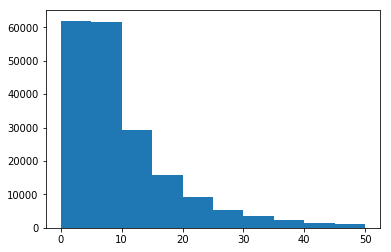

In [4]:
src_train_ids_len = [len(ids) for ids in src_train_ids]
plt.hist(src_train_ids_len, range=(0, 50))
plt.show()

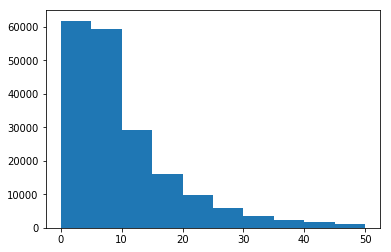

In [5]:
tgt_train_ids_len = [len(ids) for ids in tgt_train_ids]
plt.hist(tgt_train_ids_len, range=(0, 50))
plt.show()

In [6]:
hist, bin_edges = np.histogram(src_train_ids_len, range=(0, 100), bins=10)
print('hist', hist)
print('bins', bin_edges)
print('weight', hist / hist.sum())

hist [123646  44918  14467   5683   2464   1150    636    314    184    136]
bins [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
weight [ 0.63867395  0.23201686  0.07472701  0.02935464  0.0127274   0.00594014
  0.00328516  0.00162192  0.00095042  0.00070249]


random bucket [4]


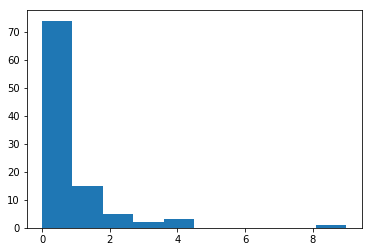

In [7]:
print('random bucket', np.random.choice(np.arange(len(hist)), 1, p=hist / hist.sum()))
picked_bucket = []
for i in range(100):
    picked_bucket.append(np.random.choice(np.arange(len(hist)), 1, p=hist / hist.sum())[0])
plt.hist(picked_bucket)
plt.show()

In [30]:
def bucket_ids(idss):
    lens = [len(ids) for ids in idss]
    hist, bin_edges = np.histogram(lens, range=(0, 100), bins=10)
    print('hist', hist)
    print('sum', np.sum(hist))
    print('bin_edges', bin_edges)
    buckets = [[] for _ in bin_edges]
    for ids in idss:
        length = len(ids)
        no_bucket = True
        for j in range(len(bin_edges) - 1, -1, -1):
            if length >= bin_edges[j]:
                no_bucket = False
                buckets[j].append(ids)
                break
        if no_bucket:
            print('no bucket for', length)
    return buckets

hist [123646  44918  14467   5683   2464   1150    636    314    184    136]
sum 193598
bin_edges [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]
buckets len [123646, 44918, 14467, 5683, 2464, 1150, 636, 314, 184, 126, 259]
sum 193847


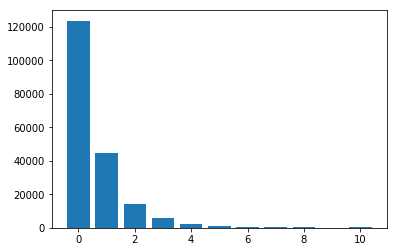

In [31]:
buckets = bucket_ids(src_train_ids)
buckets_lens = [len(b) for b in buckets]
print('buckets len', buckets_lens)
print('sum', np.sum(buckets_lens))
plt.bar(range(0, len(buckets)), buckets_lens)
plt.show()

In [10]:
def bucket_ids(src_ids, tgt_ids):
    lens = [len(ids) for ids in src_ids]
    hist, bin_edges = np.histogram(lens, range=(0, 100), bins=10)
    src_buckets = [[] for _ in bin_edges]
    tgt_buckets = [[] for _ in bin_edges]
    for ids, t_ids in zip(src_ids, tgt_ids):
        length = len(ids)
        for j in range(len(bin_edges) - 1, -1, -1):
            if length >= bin_edges[j]:
                src_buckets[j].append(ids)
                tgt_buckets[j].append(t_ids)
                break
    t = 0
    for b in src_buckets:
        t += len(b)
    print(t, len(src_ids))
    assert t == len(src_ids)
    return src_buckets, tgt_buckets

In [11]:
src_buckets, tgt_buckets = bucket_ids(src_train_ids, tgt_train_ids)

193847 193847


## Playground

In [4]:
cleaner =  re.compile('(<u>|</u>|\[|\])')
cleaner.sub('', 'I am <u>a</u> fan of [mr bruce]')

'I am a fan of mr bruce'